Author: David Simmons

Description: Classifying movie reviews using GloVe and an RNN

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os
from tqdm.notebook import tqdm
import numpy as np
import re
import random
from datetime import datetime
import matplotlib.pyplot as plt

torch.manual_seed(1)
torch.cuda.empty_cache()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
# read in vocab and embeddings from GloVe
glove_path = 'glove.6B.300d.txt'

embedding_dim = 300
glove_vocab_size = 400000

glove_vocab = []
glove_vectors = torch.empty((glove_vocab_size, embedding_dim), dtype=torch.float)

with open(glove_path, 'r', encoding='UTF-8') as f:
    for i, line in enumerate(tqdm(f.readlines())):
        parsed_line = line.split()
        glove_vocab += [parsed_line[0]]
        glove_vectors[i,:] = torch.reshape(torch.tensor(list(map(float, parsed_line[1:])), dtype=torch.float), (1,embedding_dim))

  0%|          | 0/400000 [00:00<?, ?it/s]

In [3]:
glove_idx = torch.LongTensor(torch.zeros(glove_vocab_size,dtype=int))
for idx in range(glove_vocab_size):
    glove_idx[idx] = idx + 1

In [4]:
vocab = ['<pad>'] + glove_vocab
padding_index = 0

vocab_dict = {}
for idx in range(len(vocab)):
    vocab_dict[vocab[idx]] = idx
    
# read in train filepath
train_dir = 'review_polarity/txt_sentoken/train'
train_data_unshuffled = []

pos_dir = train_dir + '/pos'
for filename in tqdm(os.listdir(pos_dir)):
    if filename.endswith(".txt"):
        filepath = pos_dir + '/' + filename
        train_data_unshuffled += [(filepath, 1)]

neg_dir = train_dir + '/neg'
for filename in tqdm(os.listdir(neg_dir)):
    if filename.endswith(".txt"):
        filepath = neg_dir + '/' + filename
        train_data_unshuffled += [(filepath, 0)]
        
train_data = random.sample(train_data_unshuffled, len(train_data_unshuffled))
train_size = len(train_data)

train_vocab = []
for filename, _ in tqdm(train_data):
    with open(filename, 'r', encoding='UTF-8') as f:
        for line in f.readlines():
            parsed_line = line.split()
            for token in parsed_line:
                if vocab_dict.get(token) == None:
                    token_split = re.split('([^a-zA-Z0-9])', token)
                    for sub_token in token_split:
                        if vocab_dict.get(sub_token) == None:
                            if sub_token != '':
                                vocab_dict[sub_token] = len(vocab_dict)
                                vocab += [sub_token]
                                train_vocab += [sub_token]

vocab_size = len(vocab)

  0%|          | 0/705 [00:00<?, ?it/s]

  0%|          | 0/695 [00:00<?, ?it/s]

  0%|          | 0/1400 [00:00<?, ?it/s]

In [5]:
# read in train dataset
train_dir = 'review_polarity/txt_sentoken/train'

train_file_to_idx = {}
train_idx_to_file = np.empty(train_size, dtype=np.dtype('U100'))
train_idx_to_label = np.empty(train_size, dtype=int)

train_idx_to_vector = {}
train_idx_to_length = np.empty(train_size, dtype=int)

for idx, (filename, label) in tqdm(enumerate(train_data)):
    train_file_to_idx[filename] = idx
    train_idx_to_file[idx] = filename
    train_idx_to_label[idx] = label
    
    vector = []
    with open(filename, 'r', encoding='UTF-8') as f:
        for line in f.readlines():
            parsed_line = line.split()
            for token in parsed_line:
                if vocab_dict.get(token) != None:
                    vector += [vocab_dict[token]]
                else:
                    token_split = re.split('([^a-zA-Z0-9])', token)
                    for sub_token in token_split:
                        if vocab_dict.get(sub_token) != None and sub_token != '':
                            vector += [vocab_dict[sub_token]]
    train_idx_to_vector[idx] = vector
    train_idx_to_length[idx] = len(vector)
    
train_idx = list(range(train_size))

0it [00:00, ?it/s]

In [6]:
# read in dev filepath
dev_dir = 'review_polarity/txt_sentoken/dev'
dev_data_unshuffled = []

pos_dir = dev_dir + '/pos'
for filename in tqdm(os.listdir(pos_dir)):
    if filename.endswith(".txt"):
        filepath = pos_dir + '/' + filename
        dev_data_unshuffled += [(filepath, 1)]

neg_dir = dev_dir + '/neg'
for filename in tqdm(os.listdir(neg_dir)):
    if filename.endswith(".txt"):
        filepath = neg_dir + '/' + filename
        dev_data_unshuffled += [(filepath, 0)]
        
dev_data = random.sample(dev_data_unshuffled, len(dev_data_unshuffled))
dev_size = len(dev_data)

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

In [7]:
# read in dev dataset
dev_dir = 'review_polarity/txt_sentoken/dev'

dev_file_to_idx = {}
dev_idx_to_file = np.empty(dev_size, dtype=np.dtype('U100'))
dev_idx_to_label = np.empty(dev_size, dtype=int)

dev_idx_to_vector = {}
dev_idx_to_length = np.empty(train_size, dtype=int)

for idx, (filename, label) in tqdm(enumerate(dev_data)):
    dev_file_to_idx[filename] = idx
    dev_idx_to_file[idx] = filename
    dev_idx_to_label[idx] = label
    
    vector = []
    with open(filename, 'r', encoding='UTF-8') as f:
        for line in f.readlines():
            parsed_line = line.split()
            for token in parsed_line:
                if vocab_dict.get(token) != None:
                    vector += [vocab_dict[token]]
                else:
                    token_split = re.split('([^a-zA-Z0-9])', token)
                    for sub_token in token_split:
                        if vocab_dict.get(sub_token) != None and sub_token != '':
                            vector += [vocab_dict[sub_token]]
    dev_idx_to_vector[idx] = vector
    dev_idx_to_length[idx] = len(vector)
    
dev_idx = list(range(dev_size))

0it [00:00, ?it/s]

In [8]:
# read in test filepath
test_dir = 'review_polarity/txt_sentoken/test'
test_data_unshuffled = []

pos_dir = test_dir + '/pos'
for filename in tqdm(os.listdir(pos_dir)):
    if filename.endswith(".txt"):
        filepath = pos_dir + '/' + filename
        test_data_unshuffled += [(filepath, 1)]

neg_dir = test_dir + '/neg'
for filename in tqdm(os.listdir(neg_dir)):
    if filename.endswith(".txt"):
        filepath = neg_dir + '/' + filename
        test_data_unshuffled += [(filepath, 0)]
        
test_data = random.sample(test_data_unshuffled, len(test_data_unshuffled))
test_size = len(test_data)

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

In [9]:
# read in test dataset
test_dir = 'review_polarity/txt_sentoken/test'

test_file_to_idx = {}
test_idx_to_file = np.empty(test_size, dtype=np.dtype('U100'))
test_idx_to_label = np.empty(test_size, dtype=int)

test_idx_to_vector = {}
test_idx_to_length = np.empty(train_size, dtype=int)

for idx, (filename, label) in tqdm(enumerate(test_data)):
    test_file_to_idx[filename] = idx
    test_idx_to_file[idx] = filename
    test_idx_to_label[idx] = label
    
    vector = []
    with open(filename, 'r', encoding='UTF-8') as f:
        for line in f.readlines():
            parsed_line = line.split()
            for token in parsed_line:
                if vocab_dict.get(token) != None:
                    vector += [vocab_dict[token]]
                else:
                    token_split = re.split('([^a-zA-Z0-9])', token)
                    for sub_token in token_split:
                        if vocab_dict.get(sub_token) != None and sub_token != '':
                            vector += [vocab_dict[sub_token]]
    test_idx_to_vector[idx] = vector
    test_idx_to_length[idx] = len(vector)
    
test_idx = list(range(test_size))

0it [00:00, ?it/s]

In [10]:
# functions
def batch_to_padded_tensors(batch, mode):
    if mode == 'train':
        idx_to_vector = train_idx_to_vector
        idx_to_length = train_idx_to_length
    elif mode == 'dev':
        idx_to_vector = dev_idx_to_vector
        idx_to_length = dev_idx_to_length
    elif mode == 'test':
        idx_to_vector = test_idx_to_vector
        idx_to_length = test_idx_to_length
    
    size = len(batch)
    lengths = idx_to_length[batch].reshape(size)
    max_length = max(lengths)
    
    tensors = torch.zeros((size, max_length), dtype=int).long()
    for i, idx in enumerate(batch):
        tensors[i, 0:idx_to_length[idx]] = torch.LongTensor(idx_to_vector[idx.item()])
               
    return tensors.to(device)

def batch_to_labels(batch, mode):
    if mode == 'train':
        idx_to_label = train_idx_to_label
    elif mode == 'dev':
        idx_to_label = dev_idx_to_label
    elif mode == 'test':
        idx_to_label = test_idx_to_label
    
    size = len(batch)
    labels = idx_to_label[batch].reshape(size)
        
    return torch.LongTensor(labels).to(device)

In [11]:
#hyper-parameters
hidden_size = 512
num_labels = 2

num_epochs = 150
learning_rate = 0.001

batch_size = 10

train_loader = torch.utils.data.DataLoader(train_idx, batch_size=batch_size)
dev_loader = torch.utils.data.DataLoader(dev_idx, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_idx, batch_size=batch_size)

In [12]:
class RNN_Classifier(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
    
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_index)
        
        # initialize embeddings with glove embeddings
        with torch.no_grad():
            self.embedding.weight[glove_idx] = glove_vectors
        
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.pooling = nn.AdaptiveMaxPool1d(1)
        self.hidden_to_label = nn.Linear(hidden_size, num_labels)
                
    def forward(self, document_tensors):
        """
        document_tensors : batch_size x sequence_length
        """
        batch_size, sequence_length = document_tensors.shape
        hidden_0 = torch.zeros((1, batch_size, self.hidden_size),dtype=torch.float).to(device)
        
        document_embeddings = self.embedding(document_tensors)
        rnn_out, _ = self.rnn(document_embeddings.view(batch_size, sequence_length, embedding_dim), hidden_0)
        pooling_out = self.pooling(rnn_out.transpose(1,2)).transpose(1,2)
        
        score = self.hidden_to_label(pooling_out).view(batch_size, -1)
        
        return F.log_softmax(score, dim=1)

In [13]:
def evaluate(model, data_loader, mode):
    true_pos_count = 0
    false_pos_count = 0
    true_neg_count = 0
    false_neg_count = 0

    with torch.no_grad():
        for index, batch in enumerate(data_loader):
            current_batch_size = len(batch)
            
            batch_tensors = batch_to_padded_tensors(batch, mode)
            batch_labels = batch_to_labels(batch, mode)

            log_probs = model(batch_tensors)

            predicted_labels = torch.argmax(log_probs, 1)

            for i in range(current_batch_size):
                if batch_labels[i] == 1 and predicted_labels[i] == 1:
                    true_pos_count += 1
                elif batch_labels[i] == 0 and predicted_labels[i] == 1:
                    false_pos_count += 1
                elif batch_labels[i] == 0 and predicted_labels[i] == 0:
                    true_neg_count += 1
                elif batch_labels[i] == 1 and predicted_labels[i] == 0:
                    false_neg_count += 1

    accuracy = (true_pos_count + true_neg_count) / (true_pos_count + false_pos_count + true_neg_count + false_neg_count)
    
    # compute F1 score on the class of pos reviews
    if true_pos_count + false_pos_count != 0:
        precision_pos = true_pos_count / (true_pos_count + false_pos_count)
    else: 
        precision_pos = 0
    if true_pos_count + false_neg_count != 0:
        recall_pos = true_pos_count / (true_pos_count + false_neg_count)
    else: 
        recall_pos = 0
    
    if precision_pos + recall_pos != 0:
        F1_pos = 2 * (precision_pos * recall_pos) / (precision_pos + recall_pos)
    else:
        F1_pos = 0
    
    # compute F1 score on the class of neg reviews
    if true_neg_count + false_neg_count != 0:
        precision_neg = true_neg_count / (true_neg_count + false_neg_count)
    else: 
        precision_neg = 0
    if true_neg_count + false_neg_count != 0:
        recall_neg = true_neg_count / (true_neg_count + false_pos_count)
    else: 
        recall_neg = 0
    
    if precision_neg + recall_neg != 0:
        F1_neg = 2 * (precision_neg * recall_neg) / (precision_neg + recall_neg)
    else:
        F1_neg = 0
        
    F1 = (F1_pos + F1_neg) / 2

    return accuracy, F1

In [14]:
epoch_train_accuracy = [0] * num_epochs
epoch_train_F1 = [0] * num_epochs
    
epoch_dev_accuracy = [0] * num_epochs
epoch_dev_F1 = [0] * num_epochs

def train(model, train_loader):
    start_time = datetime.now()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        print('epoch', epoch)
        for index, batch in enumerate(tqdm(train_loader)):
            current_batch_size = len(batch)
            batch_tensors = batch_to_padded_tensors(batch, 'train')
            batch_labels = batch_to_labels(batch, 'train')
            
            log_probs = model(batch_tensors)
            model.zero_grad()
            
            loss = F.nll_loss(log_probs, batch_labels)
            loss.backward()
               
            model.embedding.weight.grad[glove_idx] = 0
            
            optimizer.step()
        
        epoch_train_accuracy[epoch], epoch_train_F1[epoch] = evaluate(model, train_loader, 'train')
        print('train accuracy = {val1:0.5f}'.format(val1=epoch_train_accuracy[epoch]), 'train macro-F1 = {val2:0.5f}'.format(val2=epoch_train_F1[epoch]))
        
        epoch_dev_accuracy[epoch], epoch_dev_F1[epoch] = evaluate(model, dev_loader, 'dev')
        print('dev accuracy = {val1:0.5f}'.format(val1=epoch_dev_accuracy[epoch]), 'dev macro-F1 = {val2:0.5f}'.format(val2=epoch_dev_F1[epoch]))
        
    end_time = datetime.now()
    total_time = end_time-start_time
    
    print('total training time:', total_time)

In [15]:
model = RNN_Classifier(hidden_size).to(device)

In [16]:
train(model, train_loader)

epoch 0


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.51357 train macro-F1 = 0.47640
dev accuracy = 0.49000 dev macro-F1 = 0.43316
epoch 1


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.53071 train macro-F1 = 0.49486
dev accuracy = 0.49000 dev macro-F1 = 0.43316
epoch 2


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.54357 train macro-F1 = 0.50829
dev accuracy = 0.48667 dev macro-F1 = 0.42810
epoch 3


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.55643 train macro-F1 = 0.52095
dev accuracy = 0.50667 dev macro-F1 = 0.45039
epoch 4


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.56500 train macro-F1 = 0.52941
dev accuracy = 0.51000 dev macro-F1 = 0.45279
epoch 5


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.57714 train macro-F1 = 0.54077
dev accuracy = 0.52000 dev macro-F1 = 0.46266
epoch 6


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.58429 train macro-F1 = 0.54892
dev accuracy = 0.52667 dev macro-F1 = 0.46750
epoch 7


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.59429 train macro-F1 = 0.56091
dev accuracy = 0.53333 dev macro-F1 = 0.47759
epoch 8


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.60786 train macro-F1 = 0.57789
dev accuracy = 0.54000 dev macro-F1 = 0.47987
epoch 9


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.62143 train macro-F1 = 0.59300
dev accuracy = 0.54333 dev macro-F1 = 0.48231
epoch 10


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.63214 train macro-F1 = 0.60500
dev accuracy = 0.55333 dev macro-F1 = 0.49232
epoch 11


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.64143 train macro-F1 = 0.61634
dev accuracy = 0.56000 dev macro-F1 = 0.49723
epoch 12


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.65143 train macro-F1 = 0.62847
dev accuracy = 0.56000 dev macro-F1 = 0.49723
epoch 13


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.66143 train macro-F1 = 0.63994
dev accuracy = 0.55667 dev macro-F1 = 0.49478
epoch 14


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.67143 train macro-F1 = 0.65185
dev accuracy = 0.56333 dev macro-F1 = 0.49969
epoch 15


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.69071 train macro-F1 = 0.67488
dev accuracy = 0.56333 dev macro-F1 = 0.49969
epoch 16


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.70643 train macro-F1 = 0.69298
dev accuracy = 0.56333 dev macro-F1 = 0.49969
epoch 17


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.71857 train macro-F1 = 0.70667
dev accuracy = 0.56333 dev macro-F1 = 0.49692
epoch 18


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.72500 train macro-F1 = 0.71380
dev accuracy = 0.56667 dev macro-F1 = 0.49936
epoch 19


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.73429 train macro-F1 = 0.72386
dev accuracy = 0.57333 dev macro-F1 = 0.50980
epoch 20


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.74500 train macro-F1 = 0.73567
dev accuracy = 0.57333 dev macro-F1 = 0.50980
epoch 21


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.75500 train macro-F1 = 0.74659
dev accuracy = 0.57333 dev macro-F1 = 0.50980
epoch 22


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.76214 train macro-F1 = 0.75424
dev accuracy = 0.58000 dev macro-F1 = 0.52009
epoch 23


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.77071 train macro-F1 = 0.76383
dev accuracy = 0.58667 dev macro-F1 = 0.53021
epoch 24


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.78143 train macro-F1 = 0.77558
dev accuracy = 0.59333 dev macro-F1 = 0.54018
epoch 25


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.79071 train macro-F1 = 0.78556
dev accuracy = 0.60000 dev macro-F1 = 0.54772
epoch 26


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.79857 train macro-F1 = 0.79402
dev accuracy = 0.60333 dev macro-F1 = 0.55263
epoch 27


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.80929 train macro-F1 = 0.80527
dev accuracy = 0.61000 dev macro-F1 = 0.56234
epoch 28


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.81643 train macro-F1 = 0.81280
dev accuracy = 0.60667 dev macro-F1 = 0.55968
epoch 29


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.82286 train macro-F1 = 0.81960
dev accuracy = 0.61333 dev macro-F1 = 0.56922
epoch 30


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.82857 train macro-F1 = 0.82569
dev accuracy = 0.61333 dev macro-F1 = 0.56922
epoch 31


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.83500 train macro-F1 = 0.83244
dev accuracy = 0.61000 dev macro-F1 = 0.56854
epoch 32


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.84214 train macro-F1 = 0.83997
dev accuracy = 0.61000 dev macro-F1 = 0.56854
epoch 33


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.84857 train macro-F1 = 0.84667
dev accuracy = 0.60667 dev macro-F1 = 0.56584
epoch 34


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.85786 train macro-F1 = 0.85632
dev accuracy = 0.61333 dev macro-F1 = 0.57509
epoch 35


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.86286 train macro-F1 = 0.86147
dev accuracy = 0.62000 dev macro-F1 = 0.58422
epoch 36


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.86857 train macro-F1 = 0.86736
dev accuracy = 0.62333 dev macro-F1 = 0.58698
epoch 37


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.87214 train macro-F1 = 0.87101
dev accuracy = 0.62667 dev macro-F1 = 0.59152
epoch 38


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.87786 train macro-F1 = 0.87691
dev accuracy = 0.62667 dev macro-F1 = 0.59152
epoch 39


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.88000 train macro-F1 = 0.87911
dev accuracy = 0.63333 dev macro-F1 = 0.60050
epoch 40


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.88286 train macro-F1 = 0.88202
dev accuracy = 0.63000 dev macro-F1 = 0.59770
epoch 41


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.88643 train macro-F1 = 0.88568
dev accuracy = 0.63667 dev macro-F1 = 0.60655
epoch 42


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.88857 train macro-F1 = 0.88790
dev accuracy = 0.63333 dev macro-F1 = 0.60373
epoch 43


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.89357 train macro-F1 = 0.89301
dev accuracy = 0.63667 dev macro-F1 = 0.60959
epoch 44


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.89857 train macro-F1 = 0.89811
dev accuracy = 0.63667 dev macro-F1 = 0.60959
epoch 45


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.90214 train macro-F1 = 0.90175
dev accuracy = 0.64333 dev macro-F1 = 0.61818
epoch 46


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.90500 train macro-F1 = 0.90465
dev accuracy = 0.64667 dev macro-F1 = 0.62244
epoch 47


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.90786 train macro-F1 = 0.90755
dev accuracy = 0.65000 dev macro-F1 = 0.62667
epoch 48


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.91143 train macro-F1 = 0.91115
dev accuracy = 0.65333 dev macro-F1 = 0.63087
epoch 49


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.91643 train macro-F1 = 0.91618
dev accuracy = 0.65667 dev macro-F1 = 0.63506
epoch 50


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.92000 train macro-F1 = 0.91979
dev accuracy = 0.65667 dev macro-F1 = 0.63506
epoch 51


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.92429 train macro-F1 = 0.92412
dev accuracy = 0.65667 dev macro-F1 = 0.63506
epoch 52


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.92786 train macro-F1 = 0.92772
dev accuracy = 0.66333 dev macro-F1 = 0.64214
epoch 53


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.92929 train macro-F1 = 0.92916
dev accuracy = 0.66667 dev macro-F1 = 0.64629
epoch 54


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.93071 train macro-F1 = 0.93059
dev accuracy = 0.67000 dev macro-F1 = 0.65042
epoch 55


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.93357 train macro-F1 = 0.93347
dev accuracy = 0.67000 dev macro-F1 = 0.65042
epoch 56


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.93571 train macro-F1 = 0.93563
dev accuracy = 0.67000 dev macro-F1 = 0.65157
epoch 57


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.93786 train macro-F1 = 0.93777
dev accuracy = 0.67000 dev macro-F1 = 0.65268
epoch 58


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.94143 train macro-F1 = 0.94136
dev accuracy = 0.67000 dev macro-F1 = 0.65268
epoch 59


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.94643 train macro-F1 = 0.94637
dev accuracy = 0.66667 dev macro-F1 = 0.64971
epoch 60


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.94929 train macro-F1 = 0.94924
dev accuracy = 0.66667 dev macro-F1 = 0.64971
epoch 61


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.95071 train macro-F1 = 0.95068
dev accuracy = 0.66667 dev macro-F1 = 0.64971
epoch 62


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.95500 train macro-F1 = 0.95497
dev accuracy = 0.66000 dev macro-F1 = 0.64379
epoch 63


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.95643 train macro-F1 = 0.95640
dev accuracy = 0.66333 dev macro-F1 = 0.64780
epoch 64


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.95786 train macro-F1 = 0.95783
dev accuracy = 0.66667 dev macro-F1 = 0.65278
epoch 65


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.95857 train macro-F1 = 0.95855
dev accuracy = 0.66667 dev macro-F1 = 0.65278
epoch 66


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.96071 train macro-F1 = 0.96070
dev accuracy = 0.67000 dev macro-F1 = 0.65672
epoch 67


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.96071 train macro-F1 = 0.96070
dev accuracy = 0.67333 dev macro-F1 = 0.66065
epoch 68


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.96214 train macro-F1 = 0.96213
dev accuracy = 0.68000 dev macro-F1 = 0.66845
epoch 69


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.96286 train macro-F1 = 0.96284
dev accuracy = 0.68000 dev macro-F1 = 0.66845
epoch 70


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.96357 train macro-F1 = 0.96356
dev accuracy = 0.67667 dev macro-F1 = 0.66542
epoch 71


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.96429 train macro-F1 = 0.96427
dev accuracy = 0.68333 dev macro-F1 = 0.67313
epoch 72


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.96500 train macro-F1 = 0.96499
dev accuracy = 0.68667 dev macro-F1 = 0.67696
epoch 73


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.96714 train macro-F1 = 0.96713
dev accuracy = 0.68667 dev macro-F1 = 0.67696
epoch 74


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.96714 train macro-F1 = 0.96713
dev accuracy = 0.69000 dev macro-F1 = 0.68077
epoch 75


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.96857 train macro-F1 = 0.96856
dev accuracy = 0.69000 dev macro-F1 = 0.68077
epoch 76


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.96929 train macro-F1 = 0.96928
dev accuracy = 0.69333 dev macro-F1 = 0.68528
epoch 77


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.97000 train macro-F1 = 0.96999
dev accuracy = 0.69000 dev macro-F1 = 0.68220
epoch 78


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.97000 train macro-F1 = 0.96999
dev accuracy = 0.69000 dev macro-F1 = 0.68220
epoch 79


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.97143 train macro-F1 = 0.97142
dev accuracy = 0.69667 dev macro-F1 = 0.68968
epoch 80


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.97143 train macro-F1 = 0.97142
dev accuracy = 0.69667 dev macro-F1 = 0.68968
epoch 81


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.97286 train macro-F1 = 0.97285
dev accuracy = 0.69333 dev macro-F1 = 0.68659
epoch 82


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.97429 train macro-F1 = 0.97428
dev accuracy = 0.69333 dev macro-F1 = 0.68659
epoch 83


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.97429 train macro-F1 = 0.97428
dev accuracy = 0.69667 dev macro-F1 = 0.69030
epoch 84


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.97429 train macro-F1 = 0.97428
dev accuracy = 0.69333 dev macro-F1 = 0.68720
epoch 85


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.97429 train macro-F1 = 0.97428
dev accuracy = 0.70000 dev macro-F1 = 0.69457
epoch 86


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.97429 train macro-F1 = 0.97428
dev accuracy = 0.70000 dev macro-F1 = 0.69457
epoch 87


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.97429 train macro-F1 = 0.97428
dev accuracy = 0.70000 dev macro-F1 = 0.69457
epoch 88


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.97571 train macro-F1 = 0.97571
dev accuracy = 0.70000 dev macro-F1 = 0.69457
epoch 89


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.97643 train macro-F1 = 0.97643
dev accuracy = 0.69667 dev macro-F1 = 0.69089
epoch 90


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.97929 train macro-F1 = 0.97928
dev accuracy = 0.70000 dev macro-F1 = 0.69457
epoch 91


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.98000 train macro-F1 = 0.98000
dev accuracy = 0.69667 dev macro-F1 = 0.69145
epoch 92


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.98143 train macro-F1 = 0.98143
dev accuracy = 0.69000 dev macro-F1 = 0.68521
epoch 93


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.98143 train macro-F1 = 0.98143
dev accuracy = 0.69000 dev macro-F1 = 0.68521
epoch 94


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.98143 train macro-F1 = 0.98143
dev accuracy = 0.69333 dev macro-F1 = 0.68885
epoch 95


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.98214 train macro-F1 = 0.98214
dev accuracy = 0.69333 dev macro-F1 = 0.68885
epoch 96


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.98214 train macro-F1 = 0.98214
dev accuracy = 0.70333 dev macro-F1 = 0.69970
epoch 97


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.98286 train macro-F1 = 0.98286
dev accuracy = 0.70333 dev macro-F1 = 0.69970
epoch 98


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.98357 train macro-F1 = 0.98357
dev accuracy = 0.70667 dev macro-F1 = 0.70329
epoch 99


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.98500 train macro-F1 = 0.98500
dev accuracy = 0.70667 dev macro-F1 = 0.70329
epoch 100


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.98500 train macro-F1 = 0.98500
dev accuracy = 0.70667 dev macro-F1 = 0.70329
epoch 101


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.98571 train macro-F1 = 0.98571
dev accuracy = 0.70667 dev macro-F1 = 0.70329
epoch 102


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.98571 train macro-F1 = 0.98571
dev accuracy = 0.70667 dev macro-F1 = 0.70329
epoch 103


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.98643 train macro-F1 = 0.98643
dev accuracy = 0.70667 dev macro-F1 = 0.70329
epoch 104


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.98714 train macro-F1 = 0.98714
dev accuracy = 0.70667 dev macro-F1 = 0.70329
epoch 105


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.98714 train macro-F1 = 0.98714
dev accuracy = 0.70667 dev macro-F1 = 0.70370
epoch 106


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.98714 train macro-F1 = 0.98714
dev accuracy = 0.71333 dev macro-F1 = 0.71081
epoch 107


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.98786 train macro-F1 = 0.98786
dev accuracy = 0.71333 dev macro-F1 = 0.71081
epoch 108


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.98857 train macro-F1 = 0.98857
dev accuracy = 0.71667 dev macro-F1 = 0.71435
epoch 109


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99000 train macro-F1 = 0.99000
dev accuracy = 0.71667 dev macro-F1 = 0.71435
epoch 110


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99071 train macro-F1 = 0.99071
dev accuracy = 0.72000 dev macro-F1 = 0.71788
epoch 111


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99143 train macro-F1 = 0.99143
dev accuracy = 0.72333 dev macro-F1 = 0.72140
epoch 112


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99214 train macro-F1 = 0.99214
dev accuracy = 0.72333 dev macro-F1 = 0.72140
epoch 113


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99214 train macro-F1 = 0.99214
dev accuracy = 0.71667 dev macro-F1 = 0.71499
epoch 114


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99214 train macro-F1 = 0.99214
dev accuracy = 0.71667 dev macro-F1 = 0.71499
epoch 115


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99214 train macro-F1 = 0.99214
dev accuracy = 0.72000 dev macro-F1 = 0.71820
epoch 116


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99286 train macro-F1 = 0.99286
dev accuracy = 0.72333 dev macro-F1 = 0.72140
epoch 117


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99286 train macro-F1 = 0.99286
dev accuracy = 0.72333 dev macro-F1 = 0.72140
epoch 118


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99286 train macro-F1 = 0.99286
dev accuracy = 0.72333 dev macro-F1 = 0.72140
epoch 119


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99286 train macro-F1 = 0.99286
dev accuracy = 0.72333 dev macro-F1 = 0.72140
epoch 120


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99286 train macro-F1 = 0.99286
dev accuracy = 0.72667 dev macro-F1 = 0.72491
epoch 121


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99286 train macro-F1 = 0.99286
dev accuracy = 0.72333 dev macro-F1 = 0.72170
epoch 122


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99429 train macro-F1 = 0.99429
dev accuracy = 0.72333 dev macro-F1 = 0.72170
epoch 123


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99571 train macro-F1 = 0.99571
dev accuracy = 0.72667 dev macro-F1 = 0.72519
epoch 124


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99571 train macro-F1 = 0.99571
dev accuracy = 0.72667 dev macro-F1 = 0.72519
epoch 125


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99714 train macro-F1 = 0.99714
dev accuracy = 0.73000 dev macro-F1 = 0.72840
epoch 126


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99714 train macro-F1 = 0.99714
dev accuracy = 0.73000 dev macro-F1 = 0.72840
epoch 127


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99714 train macro-F1 = 0.99714
dev accuracy = 0.73333 dev macro-F1 = 0.73162
epoch 128


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99714 train macro-F1 = 0.99714
dev accuracy = 0.73333 dev macro-F1 = 0.73162
epoch 129


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99786 train macro-F1 = 0.99786
dev accuracy = 0.73333 dev macro-F1 = 0.73162
epoch 130


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99786 train macro-F1 = 0.99786
dev accuracy = 0.74333 dev macro-F1 = 0.74207
epoch 131


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99786 train macro-F1 = 0.99786
dev accuracy = 0.74333 dev macro-F1 = 0.74207
epoch 132


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99786 train macro-F1 = 0.99786
dev accuracy = 0.74333 dev macro-F1 = 0.74207
epoch 133


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99786 train macro-F1 = 0.99786
dev accuracy = 0.74333 dev macro-F1 = 0.74230
epoch 134


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99786 train macro-F1 = 0.99786
dev accuracy = 0.74333 dev macro-F1 = 0.74230
epoch 135


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99786 train macro-F1 = 0.99786
dev accuracy = 0.74333 dev macro-F1 = 0.74230
epoch 136


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99786 train macro-F1 = 0.99786
dev accuracy = 0.74667 dev macro-F1 = 0.74575
epoch 137


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99786 train macro-F1 = 0.99786
dev accuracy = 0.74667 dev macro-F1 = 0.74575
epoch 138


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99857 train macro-F1 = 0.99857
dev accuracy = 0.75000 dev macro-F1 = 0.74899
epoch 139


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99857 train macro-F1 = 0.99857
dev accuracy = 0.75333 dev macro-F1 = 0.75223
epoch 140


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99857 train macro-F1 = 0.99857
dev accuracy = 0.75333 dev macro-F1 = 0.75223
epoch 141


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99857 train macro-F1 = 0.99857
dev accuracy = 0.75333 dev macro-F1 = 0.75223
epoch 142


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99857 train macro-F1 = 0.99857
dev accuracy = 0.75333 dev macro-F1 = 0.75223
epoch 143


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99857 train macro-F1 = 0.99857
dev accuracy = 0.75667 dev macro-F1 = 0.75569
epoch 144


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99857 train macro-F1 = 0.99857
dev accuracy = 0.75667 dev macro-F1 = 0.75569
epoch 145


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99857 train macro-F1 = 0.99857
dev accuracy = 0.75667 dev macro-F1 = 0.75569
epoch 146


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99857 train macro-F1 = 0.99857
dev accuracy = 0.75667 dev macro-F1 = 0.75569
epoch 147


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99929 train macro-F1 = 0.99929
dev accuracy = 0.76000 dev macro-F1 = 0.75913
epoch 148


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99929 train macro-F1 = 0.99929
dev accuracy = 0.76000 dev macro-F1 = 0.75913
epoch 149


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99929 train macro-F1 = 0.99929
dev accuracy = 0.76000 dev macro-F1 = 0.75913
total training time: 0:40:25.136915


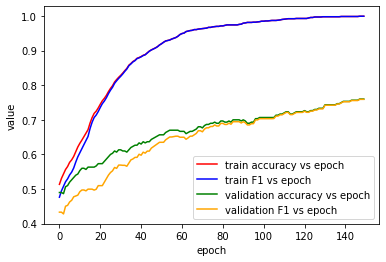

In [17]:
plt.plot(range(num_epochs), epoch_train_accuracy, label='train accuracy vs epoch', color='red' )
plt.plot(range(num_epochs), epoch_train_F1, label='train F1 vs epoch', color='blue' )
plt.plot(range(num_epochs), epoch_dev_accuracy, label='validation accuracy vs epoch', color='green' )
plt.plot(range(num_epochs), epoch_dev_F1, label='validation F1 vs epoch', color='orange' )
plt.xlabel('epoch')
plt.ylabel('value')
plt.legend()

In [18]:
test_accuracy, test_F1 = evaluate(model, test_loader, 'test')
print('test accuracy = {val1:0.5f}'.format(val1=test_accuracy), 'test macro-F1 = {val2:0.5f}'.format(val2=test_F1))

test accuracy = 0.79667 test macro-F1 = 0.79616
